# CQF - Exam 2

### Imports

In [1]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
from statistics import mean
from scipy.stats.mstats import gmean
import matplotlib.pyplot as plt
%matplotlib inline

## Question 1

Parameters

In [2]:
S0 = 100.0
T = 1.0
sigma = 0.2
r = 0.05
N = 100
dt = T / N
ts = np.arange(0, T, dt)
dB = np.concatenate((np.zeros(1), np.random.randn(N-1)*np.sqrt(dt)))
B = np.cumsum(dB)

### Euler-Maruyama scheme

$$
S_{n+1} = S_{n} + rS_{n}\Delta t + \sigma S_{n}\Delta B
$$

<AxesSubplot:>

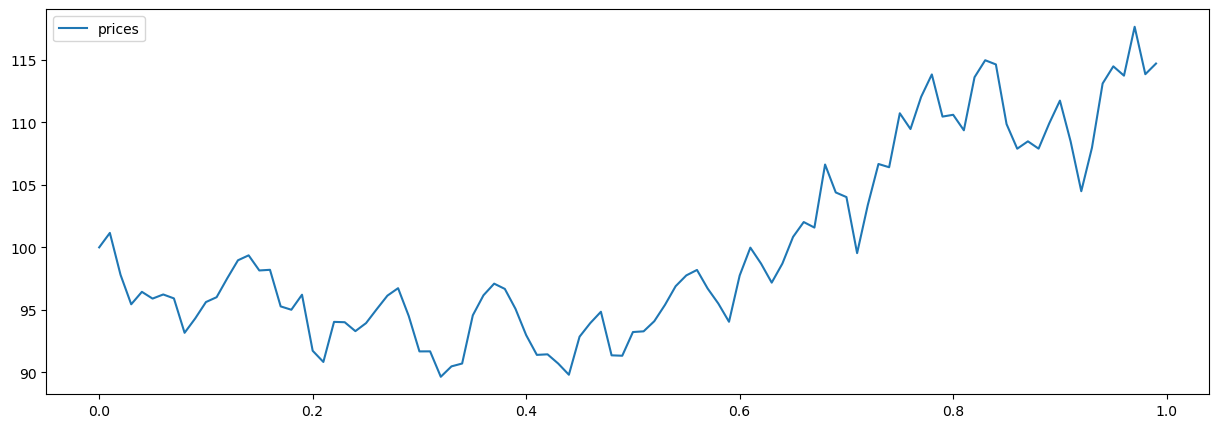

In [3]:
S = np.zeros(len(ts))
S[0] = S0

for i in range(1, len(ts)):
    S[i] = S[i-1] + r*S[i-1]*dt + sigma*S[i-1]*dB[i]

em_df = pd.DataFrame(index=ts, data=S, columns=['prices'])
em_df.plot(colormap='tab10', figsize=[15,5])

### Milstein schema

$$
S_{n+1} = S_{n} + rS_{n}\Delta t + \sigma S_{n}\Delta B + \frac{1}{2}\sigma^{2} S_{n} (\Delta B^{2} - \Delta t)
$$

<AxesSubplot:>

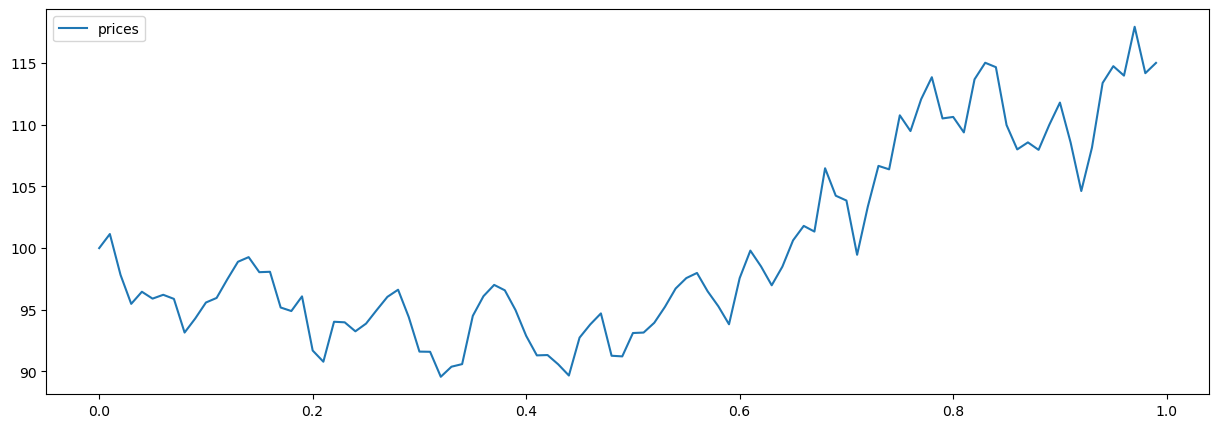

In [4]:
S = np.zeros(len(ts))
S[0] = S0

for i in range(1, len(ts)):
    S[i] = S[i-1] + r*S[i-1]*dt + sigma*S[i-1]*dB[i] \
        + 0.5*(sigma**2)*S[i-1]*(dB[i]**2-dt)

milstein_df = pd.DataFrame(index=ts, data=S, columns=['prices'])
milstein_df.plot(colormap='tab10', figsize=[15,5])

### Closed Form Solution

$$
S_{n+1} = S_{n}\exp{((r-\frac{\sigma^2}{2})t + \sigma B(t))}
$$

<AxesSubplot:>

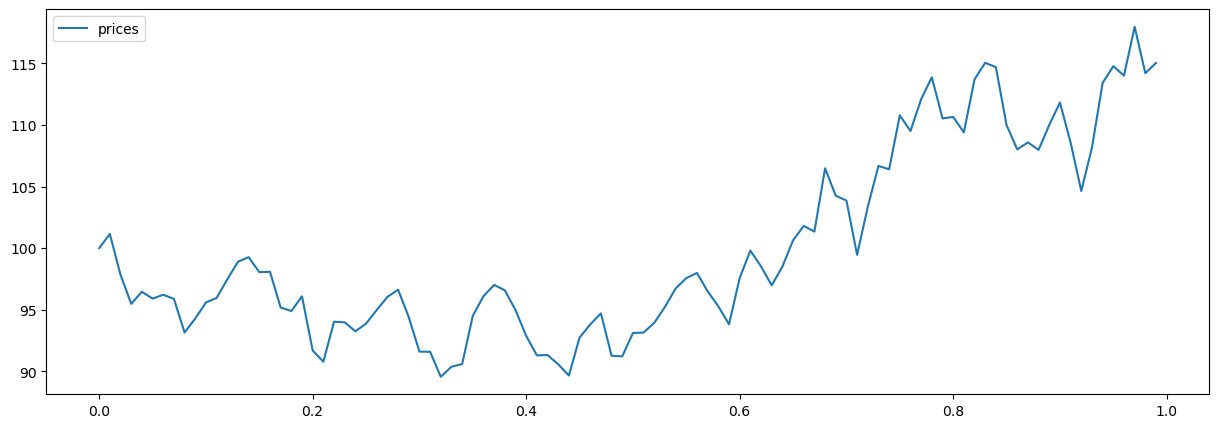

In [5]:
S = S0 * np.exp((r-0.5*sigma**2)*ts + sigma*B)
closed_df = pd.DataFrame(index=ts, data=S, columns=['prices'])
closed_df.plot(colormap='tab10', figsize=[15,5])

### Schemas Comparison

<AxesSubplot:>

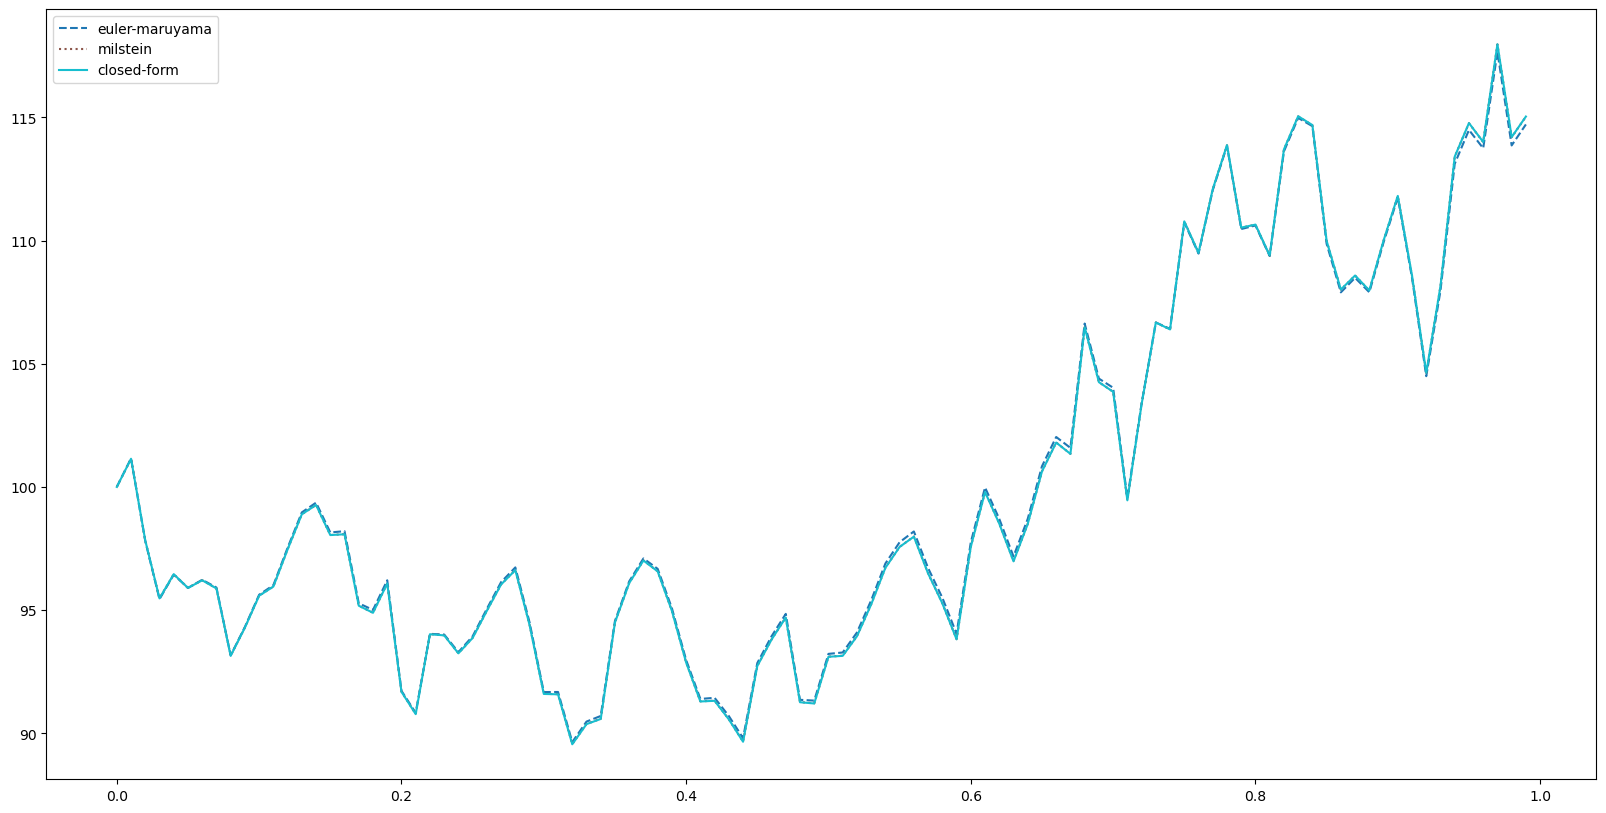

In [6]:
compare_df = em_df.copy()
compare_df.columns = ['euler-maruyama']
compare_df['milstein'] = milstein_df['prices']
compare_df['closed-form'] = closed_df['prices']
compare_df.plot(style=['--', ':', '-'],colormap='tab10', figsize=[20,10])

Plot above shows that Milstein method gives us a better approximation to the close form solution. The Milstein method has an error of $O(\delta t^2)$ while Euler-Maruyama has an error of $O(\delta t)$. 

### Asian Option Payoffs

In [7]:
S0 = 100.0
T = 1.0
sigma = 0.2
r = 0.05
N = 252*4
dt = T / N
ts = np.arange(0, T, dt)
n_simul = 1000
simulations = [np.concatenate((np.zeros(1), np.random.randn(N-1)*np.sqrt(dt))) for i in range(n_simul)]

euler_paths = [] 
milstein_paths = [] 
close_paths = []

for s in simulations:
    dB = s
    B = np.cumsum(dB)
    S = np.zeros(len(ts))
    S[0] = S0

    for i in range(1, len(ts)):
        S[i] = S[i-1] + r*S[i-1]*dt + sigma*S[i-1]*s[i]

    euler_paths.append(S)

    S = np.zeros(len(ts))
    S[0] = S0

    for i in range(1, len(ts)):
        S[i] = S[i-1] + r*S[i-1]*dt + sigma*S[i-1]*s[i] \
            + 0.5*(sigma**2)*S[i-1]*(dB[i]**2-dt)

    milstein_paths.append(S)

    S = S0 * np.exp((r-0.5*sigma**2)*ts + sigma*B)
    close_paths.append(S)

Cheching if paths are been generated accordingly

Text(0.5, 1.0, 'close form paths')

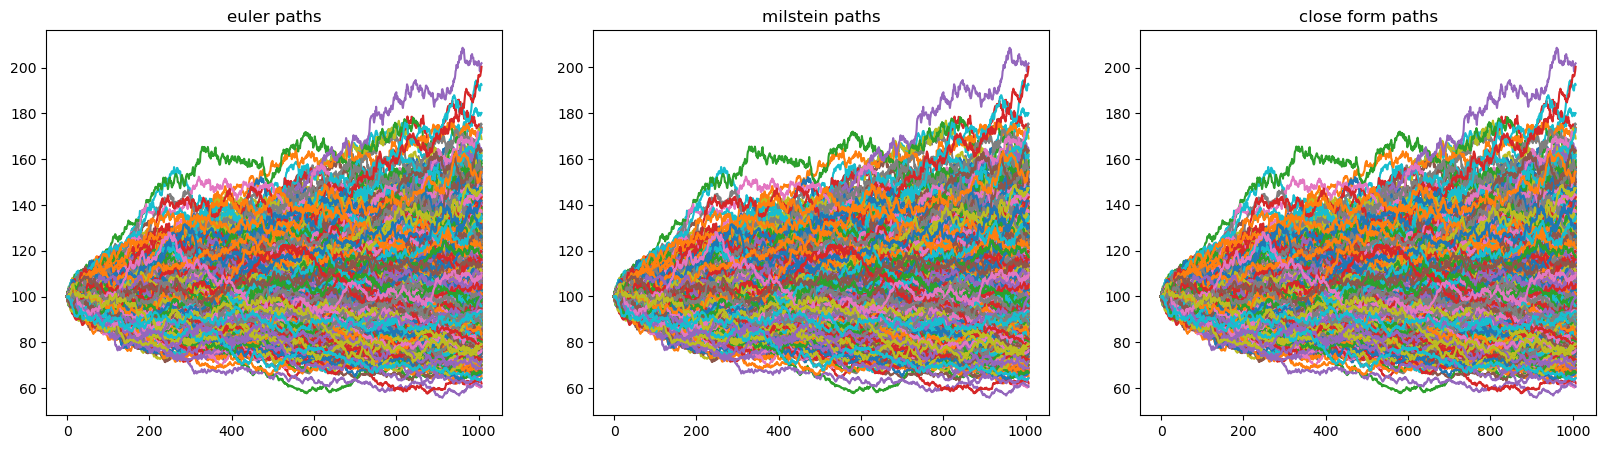

In [8]:
figure, axis = plt.subplots(1, 3, figsize=[20, 5])

for s in euler_paths:
    axis[0].plot(s)
axis[0].set_title('euler paths')

for s in milstein_paths:
    axis[1].plot(s)
axis[1].set_title('milstein paths')

for s in close_paths:
    axis[2].plot(s)
axis[2].set_title('close form paths')

In [9]:
S = np.zeros(1000)
print(int(len(S) / 252))
ttt = S[::1]
len(ttt)

3


1000

In [10]:
def vanilla_payoff(S, K, CP):
    return max(S[-1]-K, 0) if CP == 'C' else max(K-S[-1], 0)

def asian_payoff(S, K, CP, avg_func, fixed_strike=True, continuous_sampling=True):
    
    seq = 1 if continuous_sampling else int(len(S) / 252)

    if CP == 'C':
        return max(avg_func(S[::seq])-K, 0) if fixed_strike else max(S[-1]-avg_func(S[::seq]), 0)
    else:
        return max(K-avg_func(S[::seq]), 0) if fixed_strike else max(avg_func(S[::seq])-S[-1], 0)
    
E = 100

df = pd.DataFrame(index=['euler-maruyama','milstein', 'closed'], data=[
    [
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, continuous_sampling=True, fixed_strike=True) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, continuous_sampling=True, fixed_strike=True) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, continuous_sampling=True, fixed_strike=False) for S in euler_paths]), 
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, continuous_sampling=True, fixed_strike=False) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, continuous_sampling=True, fixed_strike=True) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, continuous_sampling=True, fixed_strike=True) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, continuous_sampling=True, fixed_strike=False) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, continuous_sampling=True, fixed_strike=False) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, continuous_sampling=False, fixed_strike=True) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, continuous_sampling=False, fixed_strike=True) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, continuous_sampling=False, fixed_strike=False) for S in euler_paths]), 
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, continuous_sampling=False, fixed_strike=False) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, continuous_sampling=False, fixed_strike=True) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, continuous_sampling=False, fixed_strike=True) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, continuous_sampling=False, fixed_strike=False) for S in euler_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, continuous_sampling=False, fixed_strike=False) for S in euler_paths])
    ],
    [
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, continuous_sampling=True, fixed_strike=True) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, continuous_sampling=True, fixed_strike=True) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, continuous_sampling=True, fixed_strike=False) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, continuous_sampling=True, fixed_strike=False) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, continuous_sampling=True, fixed_strike=True) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, continuous_sampling=True, fixed_strike=True) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, continuous_sampling=True, fixed_strike=False) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, continuous_sampling=True, fixed_strike=False) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, continuous_sampling=False, fixed_strike=True) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, continuous_sampling=False, fixed_strike=True) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, continuous_sampling=False, fixed_strike=False) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, continuous_sampling=False, fixed_strike=False) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, continuous_sampling=False, fixed_strike=True) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, continuous_sampling=False, fixed_strike=True) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, continuous_sampling=False, fixed_strike=False) for S in milstein_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, continuous_sampling=False, fixed_strike=False) for S in milstein_paths])
    ],
    [
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, continuous_sampling=True, fixed_strike=True) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, continuous_sampling=True, fixed_strike=True) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, continuous_sampling=True, fixed_strike=False) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, continuous_sampling=True, fixed_strike=False) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, continuous_sampling=True, fixed_strike=True) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, continuous_sampling=True, fixed_strike=True) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, continuous_sampling=True, fixed_strike=False) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, continuous_sampling=True, fixed_strike=False) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, continuous_sampling=False, fixed_strike=True) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, continuous_sampling=False, fixed_strike=True) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=mean, continuous_sampling=False, fixed_strike=False) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=mean, continuous_sampling=False, fixed_strike=False) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, continuous_sampling=False, fixed_strike=True) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, continuous_sampling=False, fixed_strike=True) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='C', avg_func=gmean, continuous_sampling=False, fixed_strike=False) for S in close_paths]),
        np.exp(-r*T)*mean([asian_payoff(S=S, K=E, CP='P', avg_func=gmean, continuous_sampling=False, fixed_strike=False) for S in close_paths])
    ]],
    columns=[
        'call mean fixed strike cont. sampl', 
        'put mean fixed strike cont. sampl', 
        'call mean float strie cont. sampl', 
        'put mean float strike cont. sampl', 
        'call gmean fixed strike cont. sampl', 
        'put gmean fixed strike cont. sampl', 
        'call gmean float strike cont. sampl', 
        'put gmean float strike cont. sampl',
       
        'call mean fixed strike fixed sampl', 
        'put mean fixed strike fixed sampl', 
        'call mean float strie fixed sampl', 
        'put mean float strike fixed sampl', 
        'call gmean fixed strike fixed sampl', 
        'put gmean fixed strike fixed sampl', 
        'call gmean float strike fixed sampl', 
        'put gmean float strike fixed sampl'
        ])

df

,call mean fixed strike cont. sampl,put mean fixed strike cont. sampl,call mean float strie cont. sampl,put mean float strike cont. sampl,call gmean fixed strike cont. sampl,put gmean fixed strike cont. sampl,call gmean float strike cont. sampl,put gmean float strike cont. sampl,call mean fixed strike fixed sampl,put mean fixed strike fixed sampl,call mean float strie fixed sampl,put mean float strike fixed sampl,call gmean fixed strike fixed sampl,put gmean fixed strike fixed sampl,call gmean float strike fixed sampl,put gmean float strike fixed sampl
euler-maruyama,5.716267,3.414890,6.061806,3.161111,5.495503,3.533705,6.282499,3.042223,5.702478,3.408363,6.075195,3.167236,5.481731,3.527231,6.295865,3.048292
milstein,5.715493,3.414746,6.059253,3.159913,5.494835,3.533534,6.279904,3.041118,5.701706,3.408217,6.072626,3.166028,5.481078,3.527069,6.293218,3.047141
closed,5.715749,3.414942,6.059524,3.160097,5.495069,3.533741,6.280195,3.041289,5.701962,3.408413,6.072897,3.166212,5.481312,3.527276,6.293511,3.047313


## Question 2

The model problem:

$$
\begin{equation}
    \frac{d^2y}{dx^2} = P(x)\frac{dy}{dx}+Q(x)y = f(x)
\end{equation}
$$

with boundary conditions:

$$
y(a) = \alpha \\
y(b) = \beta
$$

Let

$$
y_i=y(x_i), P_i=P(x_i), Q_i=Q(x_i), f_i=f(x_i)
$$

and using a Taylor serie expansion we can approximante the derivative terms as following:

$$
\begin{equation} \tag{2}
    \frac{dy}{dx} \approx \frac{y_{i+1} - y_{i-1}}{2\delta x} \\
\end{equation}
$$

$$
\begin{equation} \tag{3}
    \frac{d^2y}{dx^2} \approx \frac{y_{i+1} - 2y_i + y_{i-1}}{\delta x^2} \\
\end{equation}
$$

Substituting $(2)$ and $(3)$ in $(1)$, and multiplying both sides by $\delta x^2$ we have:

$$
y_{i+1} - 2 y_i + y_{i-1} + P_i \frac{\delta x}{2}\left(y_{i+1}-y_{i-1}\right) + Q_i \delta x^2 y_i = \delta x^2 f_i
$$

and rearranging:

$$
\begin{equation} \tag{4}
    \left(1-\frac{\delta x}{2} P_i\right) y_{i-1} + (-2 + \delta x^2 Q_i) y_i + \left(1+\frac{\delta x}{2} P_i\right) y_{i+1} = \delta x^2 f_i
\end{equation}
$$

with boundary conditions:

$$
y_0 = \alpha \\
y_n = \beta
$$

To represent the problem as a matrix inversion problem $Ax = b$, we define:

$$
A_i = 1-\frac{\delta x}{2} P_i \\
B_i = -2 + \delta x^2 Q_i \\
C_i = 1+\frac{\delta x}{2} P_i
$$

And thus, the matrices $A$, $x$ and $b$ will have the form:

$$
A = 
\begin{vmatrix}
1 & 0 & 0 & 0 & \dots & 0 & 0 & 0 & 0 \\
A_1 & B_1 & C_1 & 0 & \dots & 0 & 0 & 0 & 0 \\
0 & A_2 & B_2 & C_2 & \dots & 0 & 0 & 0 & 0 \\
0 & 0 & A_3 & B_3 & \dots & 0 & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & A_{n-2} & B_{n-2} & C_{n-2} & 0 \\
0 & 0 & 0 & 0 & \dots & 0 & A_{n-1} & B_{n-1} & C_{n-1} \\
0 & 0 & 0 & 0 & \dots & 0 & 0 & 0 & 1 \\
\end{vmatrix}
$$

$$
x = 
\begin{vmatrix}
y_0 \\
y_1 \\
y_2 \\
\vdots \\
y_{n-1} \\
y_{n} \\
\end{vmatrix}
$$

$$
b = 
\begin{vmatrix}
f_0 \delta x^2= \alpha \delta x^2 \\
f_1 \delta x^2 \\
f_2 \delta x^2 \\
f_3 \delta x^2 \\
\vdots \\
f_{n-2} \delta x^2 \\
f_{n-1} \delta x^2 \\
f_{n} \delta x^2 = \beta \delta x^2
\end{vmatrix}
$$

Implementing the algorithm:

In [11]:
def solve_problem(P, Q, n, x_0, x_n, y_0, y_n, func_problem):
    delta_x = (x_n - x_0)/n 
    xs = np.arange(x_0, x_n+delta_x, delta_x)
    fs = [func_problem(i)* (delta_x**2) for i in xs]
    A = np.identity(n+1)

    for i in range(1, n):
        for j in range(0, n+1):
            if (j - i == -1):
                A[i,j] = 1 - delta_x / 2 * P
            if (j - i == 0):
                A[i,j] = -2 + (delta_x ** 2) * Q 
            if (j - i == 1):
                A[i,j] = 1 + delta_x / 2 * P 

    b = fs
    b[0] = y_0 * (delta_x**2)
    b[n] = y_n * (delta_x**2)
    ys = np.linalg.solve(A,b)
    return xs, ys

P = 3.
Q = 2.
x_0 = 1.
x_n = 6.
y_0 = 1.
y_n = 2.

df = []
for n in [10, 50, 100]:
    xs, ys = solve_problem(P=P, Q=Q, n=n, x_0=x_0, x_n=x_n, y_0=y_0, y_n=y_n, func_problem=lambda x: 4*x**2)
    df.append(pd.DataFrame(data={'x': xs, f'y [n={n}]':ys}))

df = pd.concat(df)

Solving the problem for $n=10$ and show de results for $x_i$ and $y_i$:

In [12]:
df[['x','y [n=10]']].dropna()

,x,y [n=10]
0,1.0,0.250000
1,1.5,-1725.147155
2,2.0,-1477.447562
3,2.5,-1017.648316
4,3.0,-657.634620
5,3.5,-413.165629
6,4.0,-253.194165
7,4.5,-148.857051
8,5.0,-79.849735
9,5.5,-32.891622


<AxesSubplot:xlabel='x'>

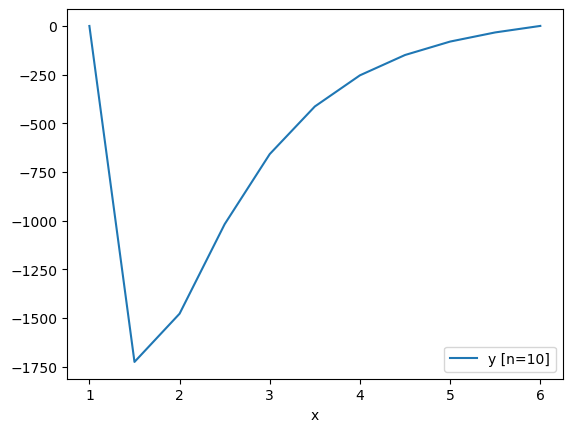

In [13]:
df.plot(x='x', y='y [n=10]')

Solving the problem for $n=50$ and show de results for $x_i$ and $y_i$:

In [14]:
df[['x','y [n=50]']].dropna()

,x,y [n=50]
0,1.0,0.010000
1,1.1,-557.008941
2,1.2,-958.989395
3,1.3,-1239.377219
4,1.4,-1425.007224
5,1.5,-1537.361102
6,1.6,-1593.590297
7,1.7,-1607.347349
8,1.8,-1589.461217
9,1.9,-1548.485532


<AxesSubplot:xlabel='x'>

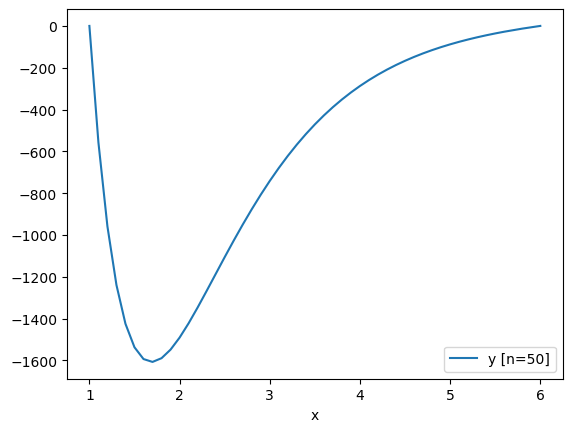

In [15]:
df.plot(x='x', y='y [n=50]')

Solving the problem for $n=100$ and show de results for $x_i$ and $y_i$:

In [16]:
df[['x','y [n=100]']].dropna()

,x,y [n=100]
0,1.00,0.002500
1,1.05,-298.470112
2,1.10,-553.896894
3,1.15,-771.095209
4,1.20,-954.387991
...,...,...
96,5.80,-12.946853
97,5.85,-9.547133
98,5.90,-6.259039
99,5.95,-3.076822


<AxesSubplot:xlabel='x'>

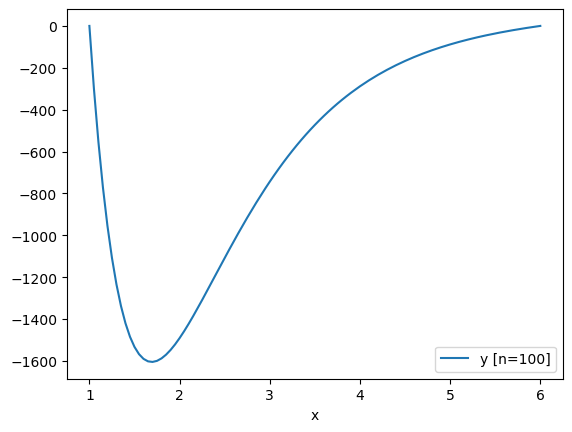

In [17]:
df.plot(x='x', y='y [n=100]')

Ploting the function for $n=10, 50, 100$, we can see that the more we increase the $n$ the better the approximation and smoother the curve.

<AxesSubplot:xlabel='x'>

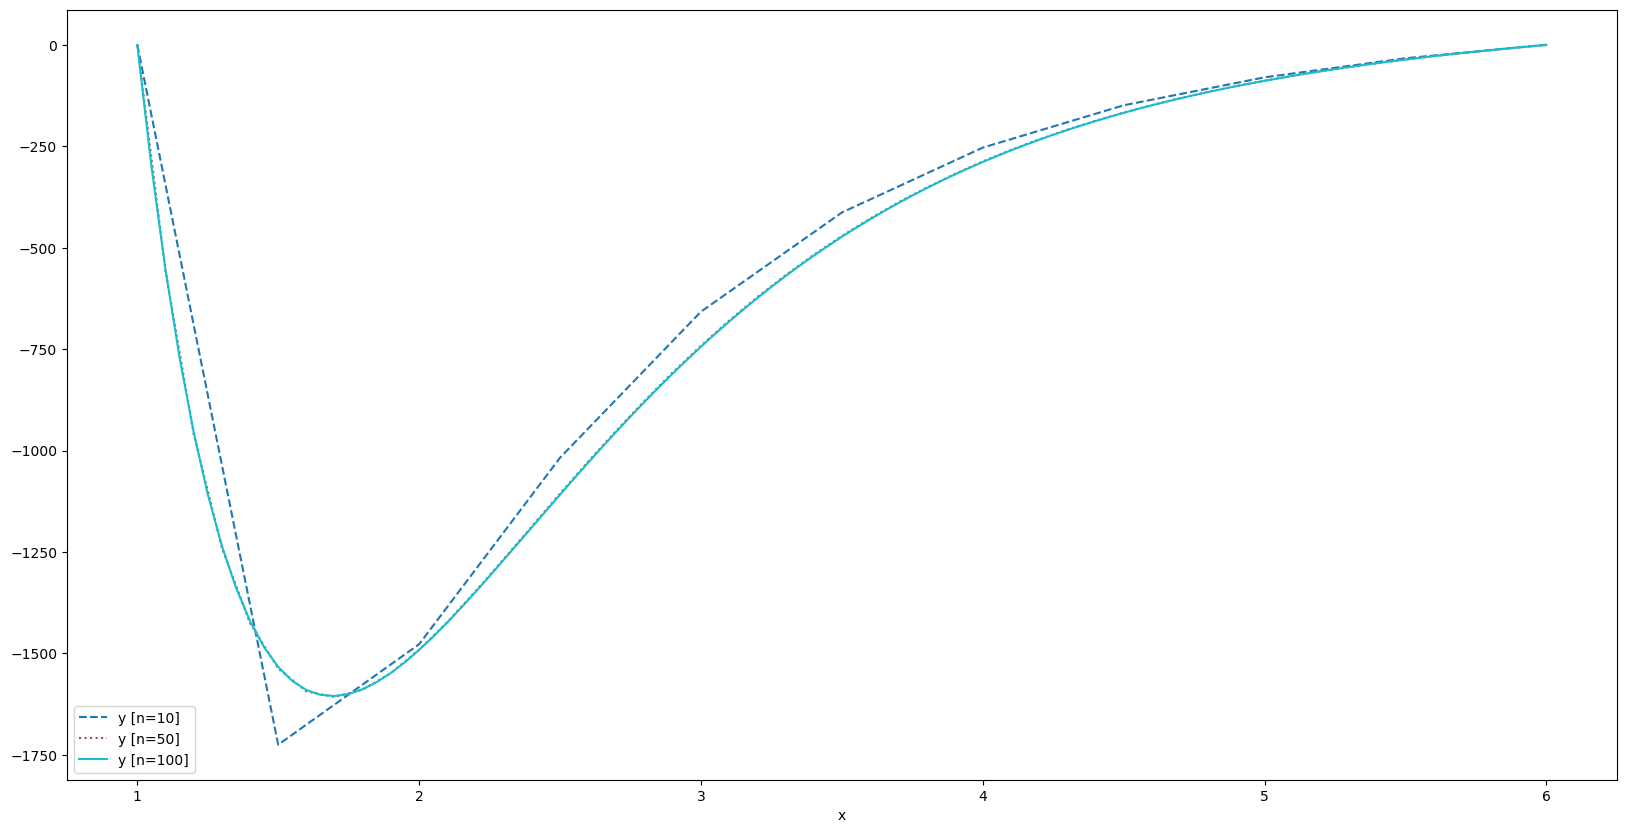

In [18]:
df.plot(x='x', style=['--', ':', '-'], colormap='tab10', figsize=[20,10])

## Question 3 - Monte Carlo Integration

Define function for Monte Carlo integration

In [164]:
def monte_carlo_integration(func, N, limit_inf, limit_sup):
    xs = np.random.uniform(limit_inf, limit_sup, size=N)
    ys = [func(x) for x in xs]
    return (limit_sup - limit_inf) / N * np.sum(ys)

I.
$$
\int_{1}^{3}x^2dx = \frac{1}{3}x^3\Biggr|_{1}^{3} =  \frac{26}{3} = 8.666667
$$

In [165]:
def func(x):
    return x**2

exact_value = 8.666667
limit_inf = 1
limit_sup = 3

In [166]:
samples = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240, 20480, 40960, 81920]
df = pd.DataFrame(data=[exact_value]*len(samples), index=samples, columns=['exact_value'])
df['mc_value'] = df.apply(lambda x: monte_carlo_integration(func, x.name, limit_inf, limit_sup), axis=1)
df['error'] = df.exact_value - df.mc_value
df

,exact_value,mc_value,error
10,8.666667,6.607261,2.059406
20,8.666667,8.491113,0.175554
40,8.666667,9.196002,-0.529335
80,8.666667,9.266938,-0.600271
160,8.666667,8.887760,-0.221093
320,8.666667,8.527673,0.138994
640,8.666667,8.536157,0.130510
1280,8.666667,8.683538,-0.016871
2560,8.666667,8.694222,-0.027555
5120,8.666667,8.665624,0.001043


Text(0, 0.5, 'error')

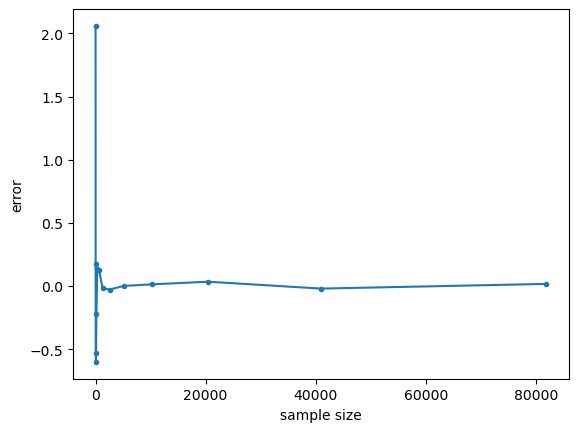

In [167]:
ax = df.error.plot(marker='.')
ax.set_xlabel('sample size')
ax.set_ylabel('error')

II.
$$
\int_{0}^{\infty}e^{-x^2}dx = \frac{1}{2}\sqrt\pi \text{erf} (x) \approx 0.886227
$$

In [168]:
def func(x):
    return np.exp(-x**2)

exact_value = 0.886227
limit_inf = 0
limit_sup = 500

In [169]:
samples = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240, 20480, 40960, 81920]
df = pd.DataFrame(data=[exact_value]*len(samples), index=samples, columns=['exact_value'])
df['mc_value'] = df.apply(lambda x: monte_carlo_integration(func, x.name, limit_inf, limit_sup), axis=1)
df['error'] = df.exact_value - df.mc_value
df

,exact_value,mc_value,error
10,0.886227,5.223262e-49,0.886227
20,0.886227,1.721681e-187,0.886227
40,0.886227,7.140643e-05,0.886156
80,0.886227,6.516088e-01,0.234618
160,0.886227,2.145406e+00,-1.259179
320,0.886227,6.482176e-01,0.238009
640,0.886227,1.728493e+00,-0.842266
1280,0.886227,1.493576e+00,-0.607349
2560,0.886227,1.039893e+00,-0.153666
5120,0.886227,1.132399e+00,-0.246172


Text(0, 0.5, 'error')

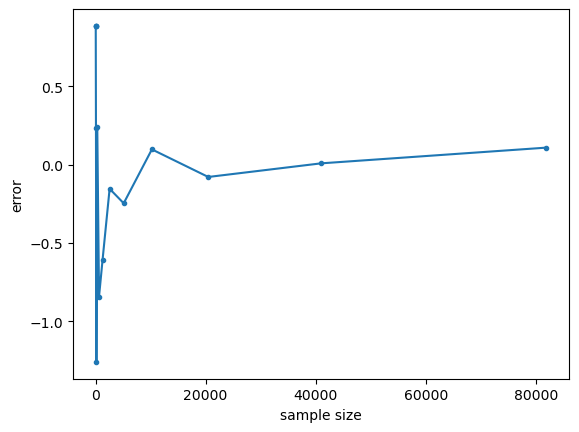

In [170]:
ax = df.error.plot(marker='.')
ax.set_xlabel('sample size')
ax.set_ylabel('error')

III.

$$
\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty}x^{4}e^{-x^2/2}dx = 0.398942 \left( 3\sqrt{\frac{\pi}{2}} \text{erf} \left(\frac{x}{\sqrt{2}}\right) - e^{-x^2/2} x ( x^2 + 3) \right) = 3
$$

In [171]:
def func(x):
    return ( 1.0 / np.sqrt(2*np.pi) ) * x**4 * np.exp(-x**2 / 2)

exact_value = 3.
limit_inf = -500
limit_sup = 500

In [173]:
samples = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240, 20480, 40960, 81920]
df = pd.DataFrame(data=[exact_value]*len(samples), index=samples, columns=['exact_value'])
df['mc_value'] = df.apply(lambda x: monte_carlo_integration(func, x.name, limit_inf, limit_sup), axis=1)
df['error'] = df.exact_value - df.mc_value
df

,exact_value,mc_value,error
10,3.0,21.869504,-18.869504
20,3.0,0.821046,2.178954
40,3.0,3.487399,-0.487399
80,3.0,0.000596,2.999404
160,3.0,0.442911,2.557089
320,3.0,3.218282,-0.218282
640,3.0,4.710162,-1.710162
1280,3.0,2.493630,0.506370
2560,3.0,3.684146,-0.684146
5120,3.0,2.523409,0.476591


Text(0, 0.5, 'error')

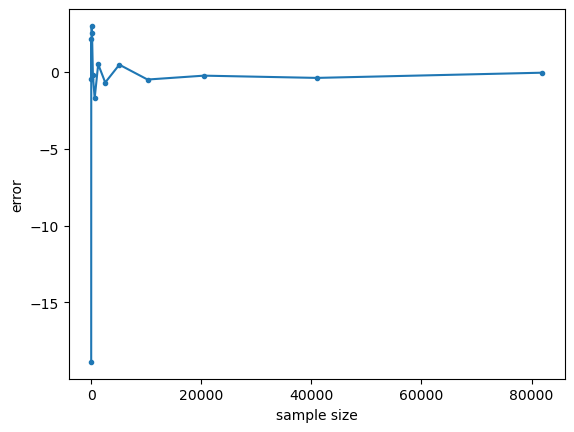

In [174]:
ax = df.error.plot(marker='.')
ax.set_xlabel('sample size')
ax.set_ylabel('error')

Hence, the plots above shows that as we increase the samples size, the error to the exact solution gets closer to $0$.

## References

- Wilmott, Paul. 2006. Paul Wilmott on Quantitative Finance. 2nd ed. Hoboken, NJ: John Wiley & Sons.
- https://kyleniemeyer.github.io/ME373-book/content/bvps/finite-difference.html